In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import seaborn as sns
import os
from torch.utils.data import DataLoader
import torch
import re
from pathlib import Path
import ipynbname

nb_path = Path(ipynbname.path())
data_path = nb_path.parent.parent
from nmt_cmr_parallels.utils.checkpoint_utils import load_recall_model
from nmt_cmr_parallels.data.sequence_data import (create_sequence_dataset, collate_fn, 
                                              create_test_dataset_from_csv)

/home/ouranos/miniconda3/envs/memseq/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def initialize_model(checkpoint_load_path, device='cuda'):
    model, vocab = load_recall_model(checkpoint_load_path, return_vocab=True, device=device)
    model.to(device)
    model.set_device(device)
    return model, vocab

Tokenizing input sequences...: 100%|██████████| 100/100 [00:00<00:00, 998643.81it/s]


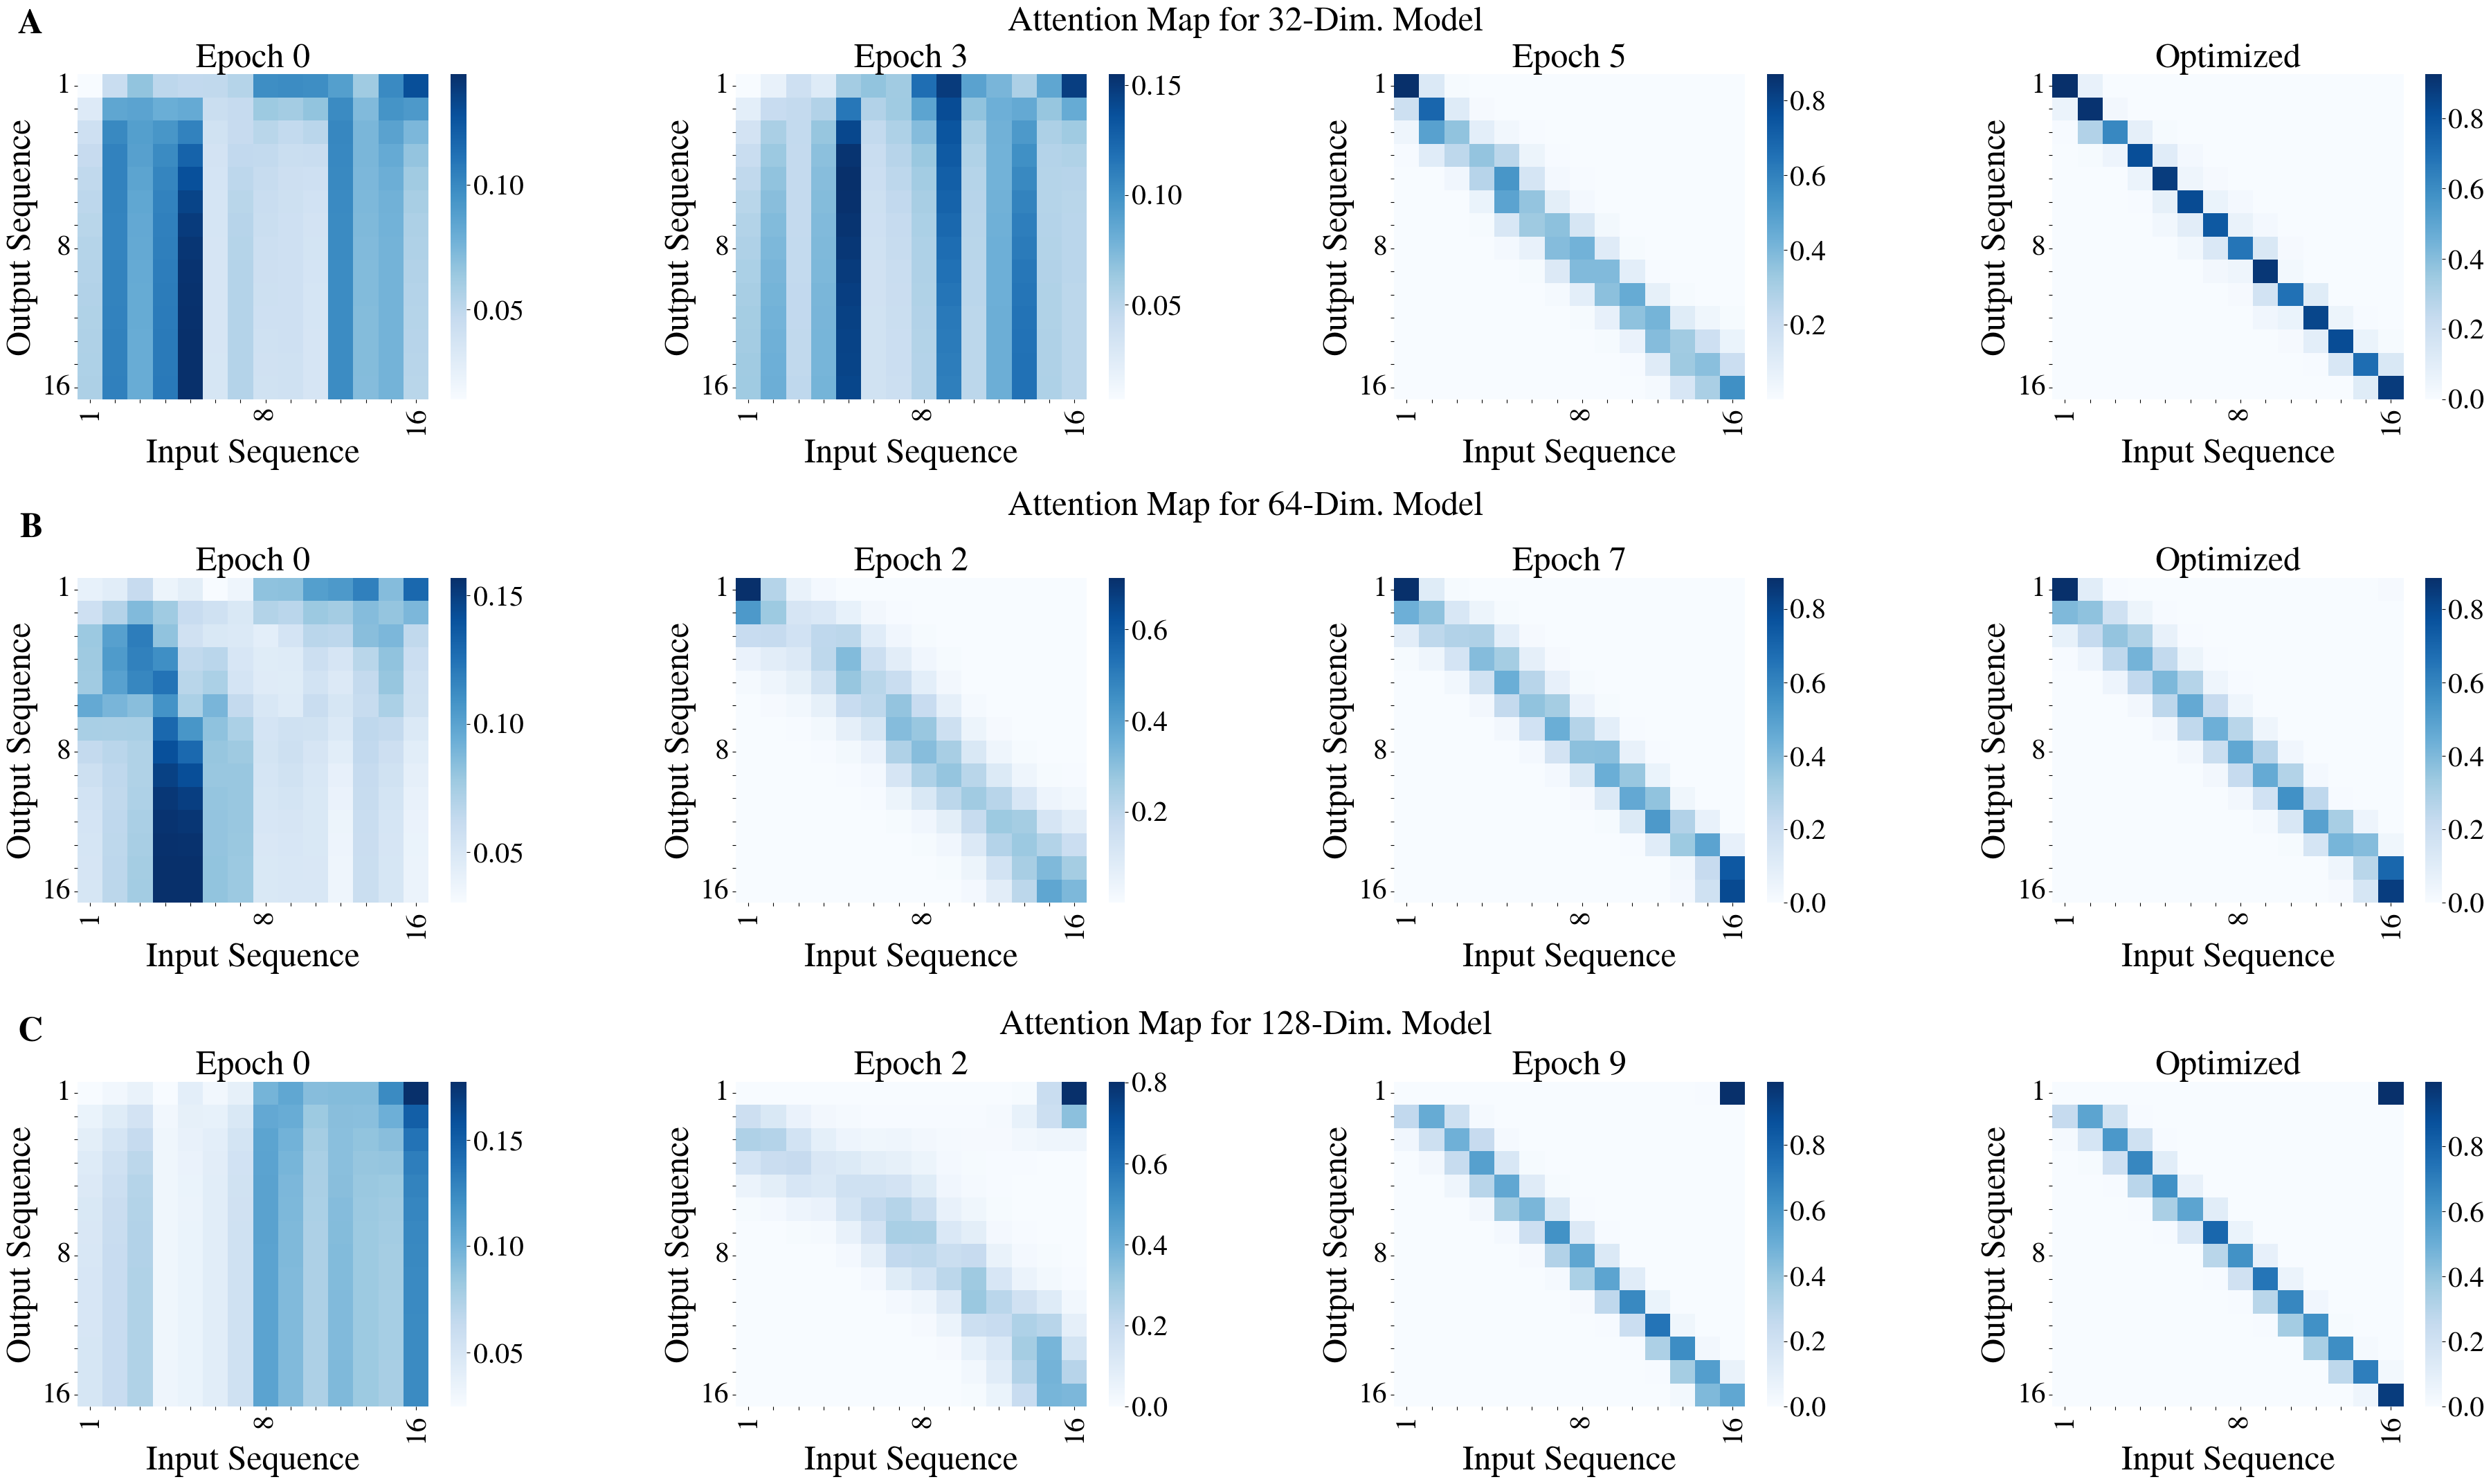

In [ ]:
bigfont = 36
smallfont = 30

# Create figure
fig = plt.figure(figsize=(45, 25))

plt.rcParams.update({
    'font.size': 30,          # base font size
    'axes.titlesize': 36,     # title size for each subplot
    'axes.labelsize': 30,     # x/y label size
    'xtick.labelsize': 30,    # tick label size
    'ytick.labelsize': 30,    # tick label size
    'legend.fontsize': 26,    # legend font size
    'font.family': 'Nimbus Roman'
})

gs = GridSpec(nrows=3, ncols=4, figure=fig, width_ratios=[1,1,1,1], height_ratios=[1,1,1])
checkpoint_path = data_path / "resource" / "pretrained_checkpoints" / "attention_128dim.pt"
model, vocab = initialize_model(str(checkpoint_path))

test_csv = None
sequence_length = 14
num_sequences = 100
vocab_size = len(vocab)

# Create DataLoader for evaluation
if test_csv is not None:
    dataset, vocab = create_test_dataset_from_csv(test_csv,
                                                    vocab=vocab,
                                                    vocab_source='peers_vocab.json',
                                                    batch_size=1)
else:
    dataset, vocab = create_sequence_dataset(sequence_length=sequence_length,
                                            num_related_words=0,
                                            num_sequences=num_sequences,
                                            vocab=vocab,
                                            vocab_size=vocab_size,
                                            scrub_vocab=False,
                                            vocab_source='peers_vocab.json')
test_loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Inverse vocabulary
vocab_index = {word: idx for idx, word in enumerate(vocab)}
inv_vocab = {v: k for k, v in vocab_index.items()}

def extract_attention_scores(atten_list):
    analyze_atten = np.array([list(x[0][0].cpu()) for x in atten_list])
    return analyze_atten

###########Attention 32 Dim ####################################
# Load and process data for each checkpoint
checkpoints = [
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_32dim" / "attention_32dim_buffered_epoch_0.pt"),
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_32dim" / "attention_32dim_buffered_epoch_3.pt"),
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_32dim" / "attention_32dim_buffered_epoch_5.pt"),
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_32dim" / "attention_32dim_buffered.pt")
]

attentions_list = []
results_list = []
titles = ["Epoch 0", "Epoch 3", "Epoch 5", "Optimized"]

for checkpoint in checkpoints:
    model, vocab = initialize_model(checkpoint)
    results = {'original_sequences': [], 'predicted_sequences': []}
    model.eval()
    attentions = []

    with torch.no_grad():
        for batch_inputs, batch_targets, seq_lengths in test_loader:
            if not isinstance(batch_inputs, list):
                batch_inputs, batch_targets = batch_inputs.to('cuda'), batch_targets.to('cuda')

            output, attention, preretrieval_output, encoder_outputs = model(batch_inputs, seq_lengths[0], return_attention=True)
            attentions.append(attention)

            predicted_indices = torch.argmax(output, dim=-1)

            original_sequences = [inv_vocab[idx] for idx in batch_inputs[0].tolist()]
            predicted_sequences = [inv_vocab[idx] if idx < len(inv_vocab) else 'Unknown' for idx in predicted_indices[0].tolist()]

            results['original_sequences'].append(original_sequences)
            results['predicted_sequences'].append(predicted_sequences)

    attentions = [extract_attention_scores(x) for x in attentions]
    attentions_list.append(attentions)
    results_list.append(results)

# Choose a sample index to plot
sample_idx = 9
# Prepare data for plotting
attention_weights_list = [attentions[sample_idx] for attentions in attentions_list]
input_sequences = [np.array(results['original_sequences'][sample_idx]) for results in results_list]
output_sequences = [np.array(results['predicted_sequences'][sample_idx]) for results in results_list]

#plot_attention(attention_weights_list, input_sequences, output_sequences, titles)

# Compute and plot averaged attention
averaged_attentions = [np.mean(np.stack(attentions, axis=0), axis=0) for attentions in attentions_list]
#labels = [f"Item {x}" for x in range(len(results['predicted_sequences'][sample_idx]))]
labels = [f"{x}" for x in range(len(results['predicted_sequences'][sample_idx]))]
labels = [labels for _ in attentions_list]

for i, (attention_weights, input_sequence, output_sequence, title) in enumerate(zip(attention_weights_list, input_sequences, output_sequences, titles)):
    ax = fig.add_subplot(gs[0, i])

    if i == 0:
        ax.text(-0.1, 1.2, 'A', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')

    attention_weights = np.array(attention_weights)
    sns.heatmap(attention_weights, xticklabels=input_sequence, yticklabels=output_sequence, cmap='Blues', ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=smallfont)
    ax.tick_params(axis='both', which='major', labelsize=smallfont)
    ax.tick_params(axis='both', which='minor', labelsize=smallfont)
    ax.set_title(title, fontsize=bigfont)
    ax.set_xlabel('Input Sequence', fontsize=bigfont)
    ax.set_ylabel('Output Sequence', fontsize=bigfont)

    ax.set_xticklabels(['1', '', '', '', '', '', '', '8', '', '', '', '', '', '16'])
    ax.set_yticklabels(['1', '', '', '', '', '', '', '8', '', '', '', '', '', '16'])

fig.text(0.5, 0.91, 'Attention Map for 32-Dim. Model', ha='center', va='center', fontsize=bigfont)

###########Attention 64 Dim ####################################
# Load and process data for each checkpoint
checkpoints = [
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_64dim" / "attention_64dim_buffered_epoch_0.pt"),
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_64dim" / "attention_64dim_buffered_epoch_2.pt"),
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_64dim" / "attention_64dim_buffered_epoch_7.pt"),
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_64dim" / "attention_64dim_buffered.pt")
]

attentions_list = []
results_list = []
titles = ["Epoch 0", "Epoch 2", "Epoch 7", "Optimized"]

for checkpoint in checkpoints:
    model, vocab = initialize_model(checkpoint)
    results = {'original_sequences': [], 'predicted_sequences': []}
    model.eval()
    attentions = []

    with torch.no_grad():
        for batch_inputs, batch_targets, seq_lengths in test_loader:
            if not isinstance(batch_inputs, list):
                batch_inputs, batch_targets = batch_inputs.to('cuda'), batch_targets.to('cuda')

            output, attention, preretrieval_output, encoder_outputs = model(batch_inputs, seq_lengths[0], return_attention=True)
            attentions.append(attention)

            predicted_indices = torch.argmax(output, dim=-1)

            original_sequences = [inv_vocab[idx] for idx in batch_inputs[0].tolist()]
            predicted_sequences = [inv_vocab[idx] if idx < len(inv_vocab) else 'Unknown' for idx in predicted_indices[0].tolist()]

            results['original_sequences'].append(original_sequences)
            results['predicted_sequences'].append(predicted_sequences)

    attentions = [extract_attention_scores(x) for x in attentions]
    attentions_list.append(attentions)
    results_list.append(results)

# Choose a sample index to plot
sample_idx = 9
# Prepare data for plotting
attention_weights_list = [attentions[sample_idx] for attentions in attentions_list]
input_sequences = [np.array(results['original_sequences'][sample_idx]) for results in results_list]
output_sequences = [np.array(results['predicted_sequences'][sample_idx]) for results in results_list]

#plot_attention(attention_weights_list, input_sequences, output_sequences, titles)

# Compute and plot averaged attention
averaged_attentions = [np.mean(np.stack(attentions, axis=0), axis=0) for attentions in attentions_list]
#labels = [f"Item {x}" for x in range(len(results['predicted_sequences'][sample_idx]))]
labels = [f"{x}" for x in range(len(results['predicted_sequences'][sample_idx]))]
labels = [labels for _ in attentions_list]

for i, (attention_weights, input_sequence, output_sequence, title) in enumerate(zip(attention_weights_list, input_sequences, output_sequences, titles)):
    ax = fig.add_subplot(gs[1, i])

    if i == 0:
        ax.text(-0.1, 1.2, 'B', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')

    attention_weights = np.array(attention_weights)
    sns.heatmap(attention_weights, xticklabels=input_sequence, yticklabels=output_sequence, cmap='Blues', ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=smallfont)
    ax.tick_params(axis='both', which='major', labelsize=smallfont)
    ax.tick_params(axis='both', which='minor', labelsize=smallfont)
    ax.set_title(title, fontsize=bigfont)
    ax.set_xlabel('Input Sequence', fontsize=bigfont)
    ax.set_ylabel('Output Sequence', fontsize=bigfont)

    ax.set_xticklabels(['1', '', '', '', '', '', '', '8', '', '', '', '', '', '16'])
    ax.set_yticklabels(['1', '', '', '', '', '', '', '8', '', '', '', '', '', '16'])

fig.text(0.5, 0.63, 'Attention Map for 64-Dim. Model', ha='center', va='center', fontsize=bigfont)

###########Attention 128 Dim ####################################
# Load and process data for each checkpoint
checkpoints = [
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_128dim" / "attention_128dim_buffered_epoch_0.pt"),
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_128dim" / "attention_128dim_buffered_epoch_2.pt"),
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_128dim" / "attention_128dim_buffered_epoch_9.pt"),
    str(data_path / "resource" / "pretrained_checkpoints" / "intermediate_128dim" / "attention_128dim_buffered.pt")
]

attentions_list = []
results_list = []
titles = ["Epoch 0", "Epoch 2", "Epoch 9", "Optimized"]

for checkpoint in checkpoints:
    model, vocab = initialize_model(checkpoint)
    results = {'original_sequences': [], 'predicted_sequences': []}
    model.eval()
    attentions = []

    with torch.no_grad():
        for batch_inputs, batch_targets, seq_lengths in test_loader:
            if not isinstance(batch_inputs, list):
                batch_inputs, batch_targets = batch_inputs.to('cuda'), batch_targets.to('cuda')

            output, attention, preretrieval_output, encoder_outputs = model(batch_inputs, seq_lengths[0], return_attention=True)
            attentions.append(attention)

            predicted_indices = torch.argmax(output, dim=-1)

            original_sequences = [inv_vocab[idx] for idx in batch_inputs[0].tolist()]
            predicted_sequences = [inv_vocab[idx] if idx < len(inv_vocab) else 'Unknown' for idx in predicted_indices[0].tolist()]

            results['original_sequences'].append(original_sequences)
            results['predicted_sequences'].append(predicted_sequences)

    attentions = [extract_attention_scores(x) for x in attentions]
    attentions_list.append(attentions)
    results_list.append(results)

# Choose a sample index to plot
sample_idx = 9
# Prepare data for plotting
attention_weights_list = [attentions[sample_idx] for attentions in attentions_list]
input_sequences = [np.array(results['original_sequences'][sample_idx]) for results in results_list]
output_sequences = [np.array(results['predicted_sequences'][sample_idx]) for results in results_list]

#plot_attention(attention_weights_list, input_sequences, output_sequences, titles)

# Compute and plot averaged attention
averaged_attentions = [np.mean(np.stack(attentions, axis=0), axis=0) for attentions in attentions_list]
#labels = [f"Item {x}" for x in range(len(results['predicted_sequences'][sample_idx]))]
labels = [f"{x}" for x in range(len(results['predicted_sequences'][sample_idx]))]
labels = [labels for _ in attentions_list]

for i, (attention_weights, input_sequence, output_sequence, title) in enumerate(zip(attention_weights_list, input_sequences, output_sequences, titles)):
    ax = fig.add_subplot(gs[2, i])

    if i == 0:
        ax.text(-0.1, 1.2, 'C', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')

    attention_weights = np.array(attention_weights)
    sns.heatmap(attention_weights, xticklabels=input_sequence, yticklabels=output_sequence, cmap='Blues', ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=smallfont)
    ax.tick_params(axis='both', which='major', labelsize=smallfont)
    ax.tick_params(axis='both', which='minor', labelsize=smallfont)
    ax.set_title(title, fontsize=bigfont)
    ax.set_xlabel('Input Sequence', fontsize=bigfont)
    ax.set_ylabel('Output Sequence', fontsize=bigfont)

    ax.set_xticklabels(['1', '', '', '', '', '', '', '8', '', '', '', '', '', '16'])
    ax.set_yticklabels(['1', '', '', '', '', '', '', '8', '', '', '', '', '', '16'])

fig.text(0.5, 0.33, 'Attention Map for 128-Dim. Model', ha='center', va='center', fontsize=bigfont)
plt.subplots_adjust(hspace=0.55, wspace=0.5)
plt.show()